2025-08-05 09:38:24.098462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754386704.311293      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754386704.380645      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


I0000 00:00:1754386725.266864      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754386725.267660      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1754386734.801499     112 service.cc:148] XLA service 0x7fad7c002370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754386734.802631     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754386734.802652     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754386735.652850     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754386767.798869     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


517/517 ━━━━━━━━━━━━━━━━━━━━ 416s 729ms/step - accuracy: 0.0650 - loss: 2.7284 - val_accuracy: 0.0473 - val_loss: 2.6922 - learning_rate: 1.0000e-04
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 299s 577ms/step - accuracy: 0.1418 - loss: 2.5406 - val_accuracy: 0.2623 - val_loss: 2.0998 - learning_rate: 1.0000e-04
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 299s 578ms/step - accuracy: 0.3385 - loss: 1.8892 - val_accuracy: 0.5835 - val_loss: 1.1939 - learning_rate: 1.0000e-04
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 297s 575ms/step - accuracy: 0.5785 - loss: 1.1484 - val_accuracy: 0.7555 - val_loss: 0.7263 - learning_rate: 1.0000e-04
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 299s 578ms/step - accuracy: 0.7871 - loss: 0.6165 - val_accuracy: 0.8857 - val_loss: 0.3451 - learning_rate: 1.0000e-04
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 297s 574ms/step - accuracy: 0.8637 - loss: 0.4006 - val_accuracy: 0.9224 - val_loss: 0.2437 - learning_rate: 1.0000e-04
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 298s 576ms/

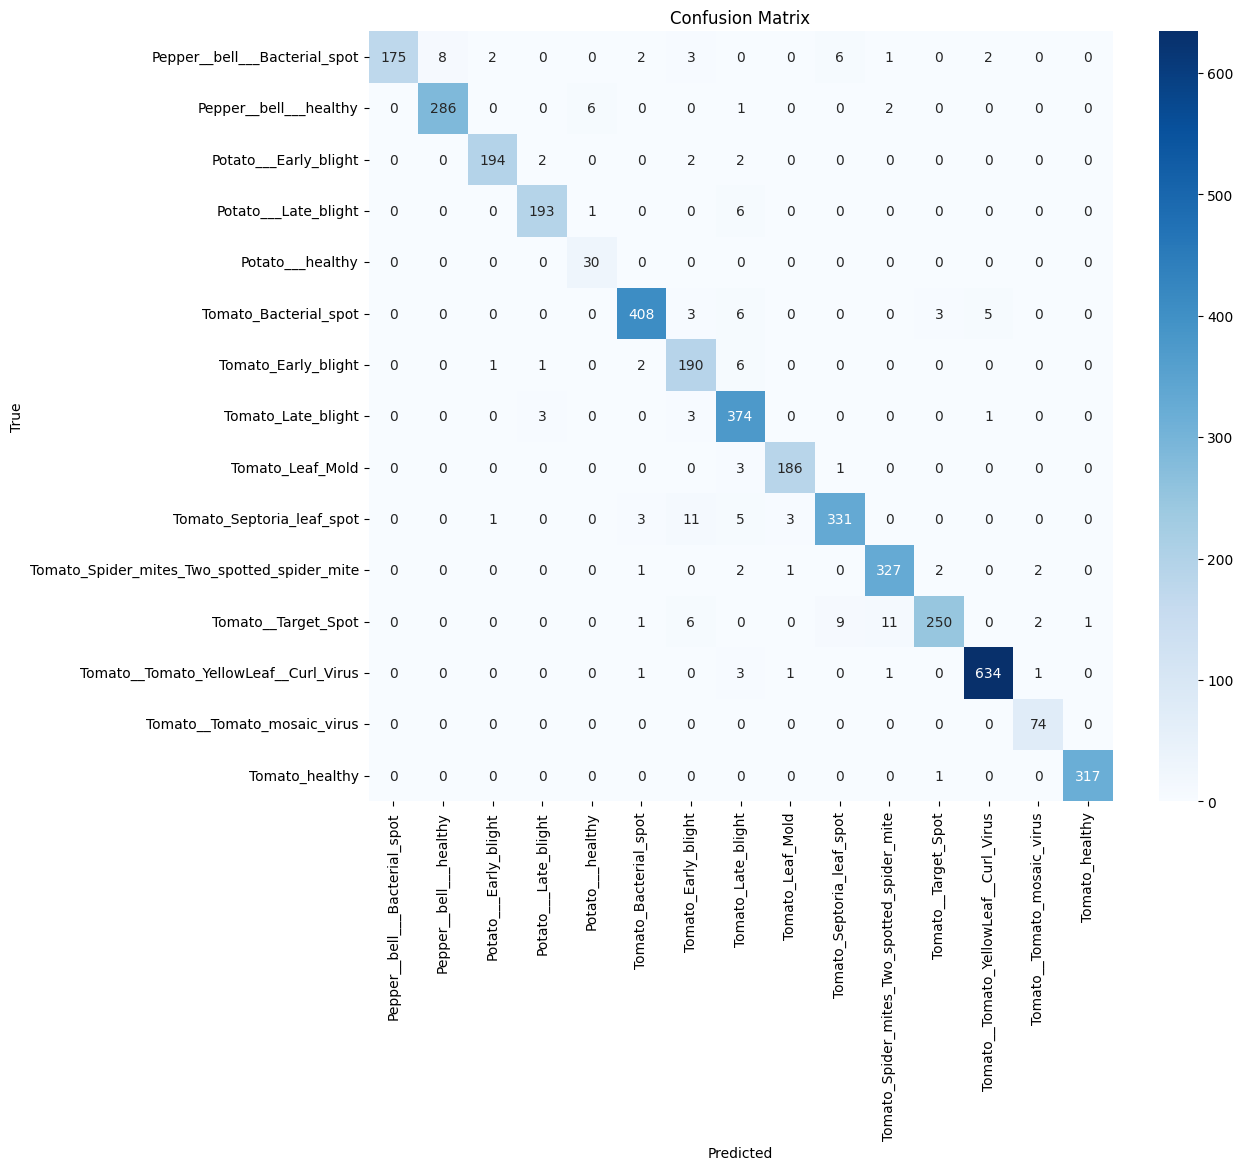

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


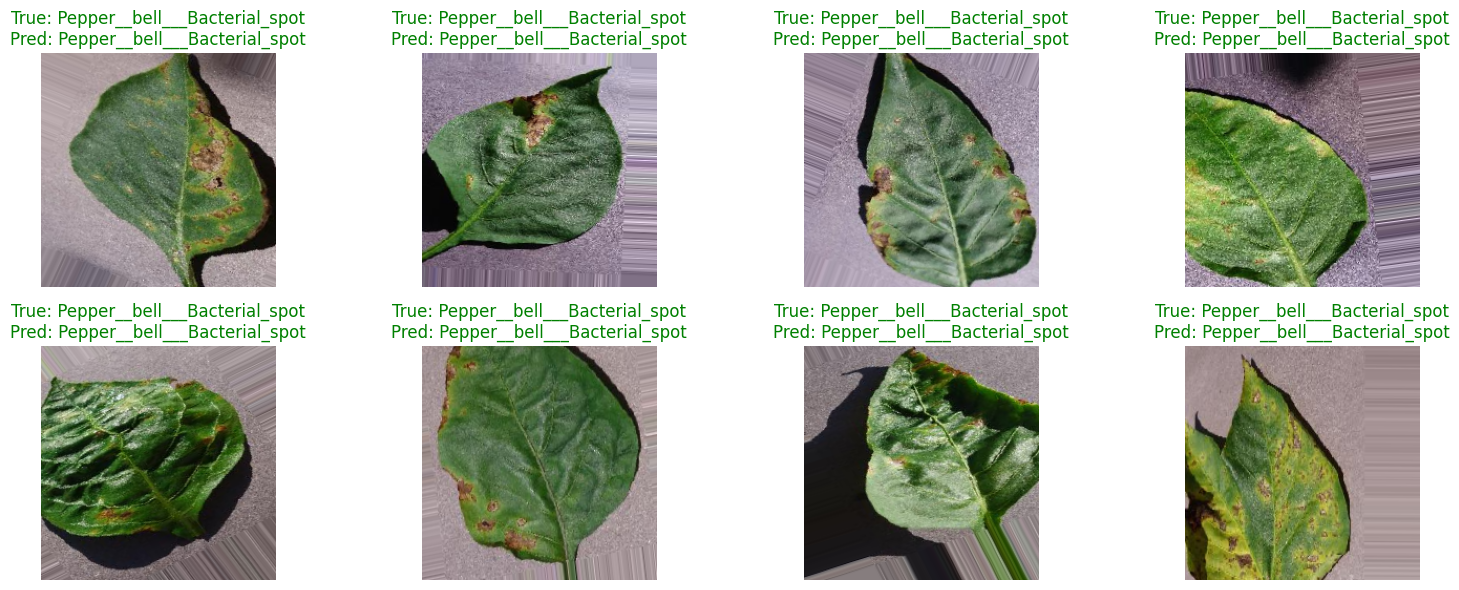

In [1]:
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# === PARAMETERS ===
img_size = 224
batch_size = 32
epochs = 10
path = "/kaggle/input/plantdisease/PlantVillage"

# === DATA GENERATORS ===
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    path, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True
)
val_gen = datagen.flow_from_directory(
    path, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False
)
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# === CLASS WEIGHTS ===
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_gen.classes),
                                     y=train_gen.classes)
class_weights_dict = dict(enumerate(class_weights))

# === MODEL ===
base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base.trainable = True  # Fine-tune entire model (can freeze first 10 layers if needed)

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base.input, outputs=out)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# === TRAIN ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                    callbacks=callbacks, class_weight=class_weights_dict)

# === EVALUATE ===
val_gen.reset()
y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
            yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# === VISUALIZE PREDICTIONS ===
x_batch, y_batch = next(val_gen)
y_true_batch = np.argmax(y_batch, axis=1)
y_pred_batch = np.argmax(model.predict(x_batch), axis=1)
plt.figure(figsize=(16, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_batch[i])
    true = class_names[y_true_batch[i]]
    pred = class_names[y_pred_batch[i]]
    plt.title(f"True: {true}\nPred: {pred}", color='green' if true==pred else 'red')
    plt.axis('off')
plt.tight_layout(); plt.show()
